# Training combined CVD ADNI models

In [1]:
print("strawberry")

import torch
from trustworthai.utils.augmentation.standard_transforms import (
    RandomFlip, GaussianBlur, GaussianNoise,
    RandomResizeCrop, RandomAffine,
    NormalizeImg, PairedCompose, LabelSelect,
    PairedCentreCrop, CropZDim,
)
from trustworthai.run.ADNI_300_analysis.ADNI_model_train import ExtractYChannelDataset as adni_ExtractYChannelDataset
from trustworthai.run.ADNI_300_analysis.ADNI_model_train import AddChannelsDataset as adni_AddChannelsDataset
from trustworthai.run.ADNI_300_analysis.ADNI_model_train import ImgsAndDfDataset as adni_ImgsAndDfDataset
from trustworthai.run.ADNI_300_analysis.ADNI_model_train import SkipBadIndexesDs as adni_SkipBadIndexesDs
from trustworthai.run.ADNI_300_analysis.ADNI_model_train import AugmentedDataset as adni_AugmentedDataset
from trustworthai.run.ADNI_300_analysis.ADNI_model_train import FormatDataset as adni_FormatDataset
from trustworthai.run.ADNI_300_analysis.ADNI_model_train import get_output_maps_for_ds as adni_get_output_maps_for_ds
from trustworthai.run.ADNI_300_analysis.ADNI_model_train import prepare_ADNI_dfs
import pandas as pd
import numpy as np
from natsort import natsorted
import os
from tqdm import tqdm
import matplotlib.pyplot as plt
from trustworthai.utils.data_preprep.splits import cross_validate_split

# training
from trustworthai.utils.fitting_and_inference.fitters.basic_lightning_fitter import StandardLitModelWrapper
from pytorch_lightning.callbacks.model_checkpoint import ModelCheckpoint
from trustworthai.utils.fitting_and_inference.get_trainer import get_trainer

from trustworthai.run.model_load.training_fazekas_3_script import build_clinscores_prediction_dataset, FormatDataset_CVD_Data, GetLabelsDs

# data
from twaidata.torchdatasets.MRI_3D_nolabels_inram_ds import MRI_3D_nolabels_inram_ds
from trustworthai.utils.data_preprep.dataset_pipelines import load_clinscores_data, load_data, ClinScoreDataRetriever
from torch.utils.data import ConcatDataset, Dataset, DataLoader
from torchsampler import ImbalancedDatasetSampler

print("banana")

strawberry
strawberry
banana
strawberry
banana
banana


In [2]:
class ResampledDataset(Dataset):
    def __init__(self, base_dataset):
        self.base_dataset = base_dataset
        labels = [y for _, y in base_dataset]
        # print(labels)
        labels = np.array(labels)
        uniques = natsorted(np.unique(labels))

        label_counts = [np.sum(labels == label) for label in uniques]
        
        largest_group_size = max(label_counts)
            
        label_positions = {label:[] for label in uniques}

        for i, label in enumerate(labels):
            label_positions[label].append(i)
            
        #label_positions = {label:}
            
        resampled_indexes = []
        for label in uniques:
            count = 0
            i = 0
            while count < largest_group_size:
                label_pos = label_positions[label]
                label_total = len(label_pos)
                resampled_indexes.append(label_pos[i % label_total])
                i += 1
                count += 1
                
        self.resampled_indexes = resampled_indexes
        # print(resampled_indexes)
        
    def __getitem__(self, idx):
        return self.base_dataset[self.resampled_indexes[idx]]
    
    def __len__(self):
        return len(self.resampled_indexes)

In [3]:
class GetLabelsDs(Dataset):
    def __init__(self, base_dataset):
        self.base_dataset = base_dataset
        
    def __getitem__(self, idx):
        return self.base_dataset[idx]
    
    def __len__(self):
        return len(self.base_dataset)
    
    def get_labels(self):
        labels = []
        for (x, clin_data), y in self.base_dataset:
            labels.append(y)
            
        return labels

In [4]:
def get_transforms():
    transforms = [
        LabelSelect(label_id=1),
        RandomFlip(p=0.5, orientation="horizontal"),
        # GaussianBlur(p=0.5, kernel_size=7, sigma=(.1, 1.5)),
        # GaussianNoise(p=0.2, mean=0, sigma=0.2),
        RandomAffine(p=0.2, shear=(-18,18)),
        RandomAffine(p=0.2, degrees=15),
        RandomAffine(p=0.2, translate=(-0.1,0.1)),
        RandomAffine(p=0.2, scale=(0.9, 1.1)),
#         #RandomResizeCrop(p=1., scale=(0.6, 1.), ratio=(3./4., 4./3.))

#         #RandomResizeCrop(p=1., scale=(0.3, 0.5), ratio=(3./4., 4./3.)) # ssn
    ]
    transforms.append(lambda x, y: (x, y.squeeze().type(torch.long)))
    return PairedCompose(transforms)


In [5]:
# # load and manipulate spreadsheet data
# adni_dir = "/home/s2208943/ipdis/data/ADNI_data/"
# spreadsheet_dir = adni_dir
# # dataset with clinical variables (e.g age, and a bunch of other factors)
# variables_df = pd.read_excel(spreadsheet_dir + "ADNI_300_Variables_for_Analysis.xlsx")

# # dataset with fazekas ratings by Maria. I only have 290 of the 298 due to a few images missing matches, which is a shame
# # but hopefully this is enough information. Nice.
# ratings_df = pd.read_excel(spreadsheet_dir + "ADNI_300_Sample_MVH_ratings.xlsx")

# combined_df = prepare_ADNI_dfs(ratings_df, variables_df)

In [6]:
# load the adni data
class ADNIDataLoader:
    def __init__(self, umap_model_name):    
        # load the adni data
        ADNI_ds = MRI_3D_nolabels_inram_ds("/home/s2208943/ipdis/data/preprocessed_data/ADNI_300")
        IDs = ADNI_ds.getIDs()

        model_name = umap_model_name
        output_maps_dir = f"/home/s2208943/ipdis/data/preprocessed_data/ADNI_300_output_maps/{model_name}/"
        output_maps, key_order = adni_get_output_maps_for_ds(output_maps_dir, IDs)


        # load and manipulate spreadsheet data
        adni_dir = "/home/s2208943/ipdis/data/ADNI_data/"
        spreadsheet_dir = adni_dir
        # dataset with clinical variables (e.g age, and a bunch of other factors)
        variables_df = pd.read_excel(spreadsheet_dir + "ADNI_300_Variables_for_Analysis.xlsx")

        # dataset with fazekas ratings by Maria. I only have 290 of the 298 due to a few images missing matches, which is a shame
        # but hopefully this is enough information. Nice.
        ratings_df = pd.read_excel(spreadsheet_dir + "ADNI_300_Sample_MVH_ratings.xlsx")

        combined_df = prepare_ADNI_dfs(ratings_df, variables_df)

        imgs_ds = ADNI_ds
        imgs_ds = adni_ExtractYChannelDataset(imgs_ds, 1)
        imgs_ds = adni_AddChannelsDataset(imgs_ds, output_maps, IDs)
        
        self.imgs_ds = imgs_ds
        self.combined_df = combined_df
    
    def get_datasets(self, split, target, input_type, add_standard_augment=True, val_prop=0.15, test_prop=0.15, seed=3407, fields = ['AGE', 'Ventricles_bl %', 'Hippocampus_bl %',
           'WholeBrain_bl %', 'Entorhinal_bl %', 'Fusiform_bl %', 'MidTemp_bl %',
           'BMI', 'PTGENDER', 'E-M RISK FACTORS',
           'DX.bl_0', 'DX.bl_1', 'DX.bl_2', 'DX.bl_3', 'CV RISK FACTORS_0',
           'CV RISK FACTORS_1', 'CV RISK FACTORS_2', 'APOE4_0', 'APOE4_1',
           'APOE4_2']):
        
        imgs_ds = self.imgs_ds
        imgs_ds = adni_ImgsAndDfDataset(imgs_ds, self.combined_df, selected_fields=fields, label_field=target)
        imgs_ds = adni_SkipBadIndexesDs(imgs_ds)
        #imgs_ds = ConsumedDataset(imgs_ds)
        
        train_ds, val_ds, test_ds = cross_validate_split(imgs_ds, val_prop=val_prop, test_prop=test_prop, seed=seed, split=split, test_fold_smooth=1)
        if add_standard_augment:
            augments = get_transforms()
        else:
            augments = None
        
        
        train_ds = adni_AugmentedDataset(train_ds, augments)
        val_ds = adni_AugmentedDataset(val_ds, augments)
        test_ds = adni_AugmentedDataset(test_ds, augments)

        if input_type == 'both':
            channels = ['ent', 'pred']
        else:
            channels = [input_type]

        train_ds_2d = adni_FormatDataset(train_ds, channels=channels)
        val_ds_2d = adni_FormatDataset(val_ds, channels=channels)
        test_ds_2d = adni_FormatDataset(test_ds, channels=channels)

        return train_ds_2d, val_ds_2d, test_ds_2d

In [7]:
umap_model_name = "CHAL_based_SSN"

In [8]:
adni_loader = ADNIDataLoader(umap_model_name=umap_model_name)

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 290/290 [04:08<00:00,  1.17it/s]
/home/s2208943/miniconda3/envs/uq/lib/python3.10/site-packages/openpyxl/worksheet/_reader.py:312: UserWarning: Unknown extension is not supported and will be removed
  warn(msg)
/home/s2208943/miniconda3/envs/uq/lib/python3.10/site-packages/openpyxl/worksheet/_reader.py:312: UserWarning: Unknown extension is not supported and will be removed
  warn(msg)


Index(['Patient ID', 'Image_year', 'PVS_BG', 'PVS_CS', 'Unnamed: 4',
       'Image_year.1', 'WMH_PV', 'WMH_Deep', 'Total', 'Obs', 'DX.bl', 'AGE',
       'PTGENDER', 'PTEDUCAT', 'PTRACCAT', 'APOE4', 'Ventricles_bl %',
       'Hippocampus_bl %', 'WholeBrain_bl %', 'Entorhinal_bl %',
       'Fusiform_bl %', 'MidTemp_bl %', 'BMB Y1 Count', 'BMB Y2 Count',
       'BMB Y3 Count', 'VSBPDIA', 'VSBPSYS', 'VSPULSE', 'BMI',
       'CV RISK FACTORS', 'E-M RISK FACTORS'],
      dtype='object')
AGE
71.68144
7.255286
Ventricles_bl %
2.0359201
1.2413726
Hippocampus_bl %
0.4417514
0.14940187
WholeBrain_bl %
63.80321
19.644567
Entorhinal_bl %
0.2250529
0.07900988
Fusiform_bl %
1.1153746
0.35392547
MidTemp_bl %
1.2349646
0.38926435
BMI
27.25382
4.750693


/home/s2208943/ipdis/UQ_WMH_methods/trustworthai/run/ADNI_300_analysis/ADNI_model_train.py:75: FutureWarning: In a future version, the Index constructor will not infer numeric dtypes when passed object-dtype sequences (matching Series behavior)
  onehot_cols = pd.get_dummies(df[field], prefix=field)
/home/s2208943/ipdis/UQ_WMH_methods/trustworthai/run/ADNI_300_analysis/ADNI_model_train.py:75: FutureWarning: In a future version, the Index constructor will not infer numeric dtypes when passed object-dtype sequences (matching Series behavior)
  onehot_cols = pd.get_dummies(df[field], prefix=field)
/home/s2208943/ipdis/UQ_WMH_methods/trustworthai/run/ADNI_300_analysis/ADNI_model_train.py:75: FutureWarning: In a future version, the Index constructor will not infer numeric dtypes when passed object-dtype sequences (matching Series behavior)
  onehot_cols = pd.get_dummies(df[field], prefix=field)


In [49]:
channel_type = 'ent'

In [9]:
adni_train, adni_val, adni_test = adni_loader.get_datasets(
    split=0,
    target='WMH_Deep',
    input_type=channel_type,
    add_standard_augment=True,
    val_prop=0.15,
    test_prop=0.15,
    seed=3407,
    fields = ['AGE', 'PTGENDER']
)

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 290/290 [00:29<00:00,  9.79it/s]


In [10]:
# load the cvd data

def load_cvd_data(clin_retriever, split, target, input_type, umap_model_name, add_standard_augment=True, val_prop=0.15, test_prop=0.15, seed=3407, clin_fields = ['age', 'sex', 'diabetes', 'hypertension', 'hyperlipidaemia', 'smoking_0', 'smoking_1', 'smoking_2']
    ):
    umap_model = umap_model_name
    
    if input_type == 'both':
        channels = ['ent', 'pred']
    else:
        channels = [input_type]
        
    if target == "DWMH" or target == "PVWMH":
        num_classes = 4
    elif target == "total_fazekas" or target == "supAtrophy" or target == "deepAtrophy":
        num_classes = 7 # includes the 6 class.
    else:
        num_classes = 2 # for stroke, or tab fazekas, or the other tab variables etc.
    
        
        
    ### load the data
    train_ds_clin, val_ds_clin, test_ds_clin = clin_retriever.load_clinscores_data(
            combine_all=False,
            test_proportion=test_prop, 
            validation_proportion=val_prop,
            seed=seed,
            cross_validate=True,
            cv_split=split,
            cv_test_fold_smooth=1,

        )
    
    ### load the extra information (e.g uncertainty maps, var maps, preds etc)
    umap_model_name = umap_model
    output_maps_dir = f"/home/s2208943/ipdis/data/preprocessed_data/EdData_output_maps/{umap_model_name}/"

    output_maps_files = os.listdir(output_maps_dir)

    ds = train_ds_clin
    
    target_field = target
    
    new_test_ds = build_clinscores_prediction_dataset(output_maps_dir, test_ds_clin, clin_fields=clin_fields, target_field=target_field,  apply_augmentation=add_standard_augment)
    new_val_ds = build_clinscores_prediction_dataset(output_maps_dir, val_ds_clin, clin_fields=clin_fields, target_field=target_field, apply_augmentation=add_standard_augment)
    new_train_ds = build_clinscores_prediction_dataset(output_maps_dir, train_ds_clin, clin_fields=clin_fields, target_field=target_field, apply_augmentation=add_standard_augment)
    
    train_ds_2d = GetLabelsDs(FormatDataset_CVD_Data(new_train_ds, channels=channels))
    val_ds_2d = GetLabelsDs(FormatDataset_CVD_Data(new_val_ds, channels=channels))
    test_ds_2d = GetLabelsDs(FormatDataset_CVD_Data(new_test_ds, channels=channels))
    
    return train_ds_2d, val_ds_2d, test_ds_2d

In [11]:
clin_retriever = ClinScoreDataRetriever(use_updated_scores=True)

In [12]:
train_ds_2d, val_ds_2d, test_ds_2d = load_cvd_data(
    clin_retriever,
    split=0,
    target="DWMH",
    input_type=channel_type,
    umap_model_name=umap_model_name,
    add_standard_augment=True,
    val_prop=0.15,
    test_prop=0.15,
    seed=3407,
    clin_fields = ['age', 'sex']
    
)
  

loading umaps and wmh preds images


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 42/42 [00:27<00:00,  1.55it/s]


loading umaps and wmh preds images


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 35/35 [00:21<00:00,  1.63it/s]


loading umaps and wmh preds images


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 173/173 [01:45<00:00,  1.64it/s]


In [13]:
class CVD_adjust_fields_dataset(torch.utils.data.Dataset):
    def __init__(self, base_dataset):
        self.base_dataset = base_dataset
        
    def __len__(self):
        return len(self.base_dataset)
    
    def __getitem__(self, idx):
        
        (x, clin_data), label = self.base_dataset[idx]
        age_mean = 71.68144
        age_std = 7.255286
        clin_data[1] -= 1.
        clin_data[0] = (clin_data[0] - age_mean) / age_std
        clin_data = torch.Tensor(clin_data)
        
        return (x, clin_data), label

In [14]:
class ADNI_torch_ds(torch.utils.data.Dataset):
    def __init__(self, base_dataset):
        self.base_dataset = base_dataset
        
    def __len__(self):
        return len(self.base_dataset)
    
    def __getitem__(self, idx):
        
        (x, clin_data), label = self.base_dataset[idx]
        clin_data = torch.Tensor(clin_data)
        
        return (x, clin_data), label

In [15]:
cvd_train = CVD_adjust_fields_dataset(train_ds_2d)
cvd_val = CVD_adjust_fields_dataset(val_ds_2d)
cvd_test = CVD_adjust_fields_dataset(test_ds_2d)

In [16]:
tadni_train = ADNI_torch_ds(adni_train)
tadni_val = ADNI_torch_ds(adni_val)
tadni_test = ADNI_torch_ds(adni_test)

In [17]:
example0 = adni_train[7]
example1 = cvd_train[0]

In [18]:
example0[1]

3.0

In [19]:
example0[1]

3.0

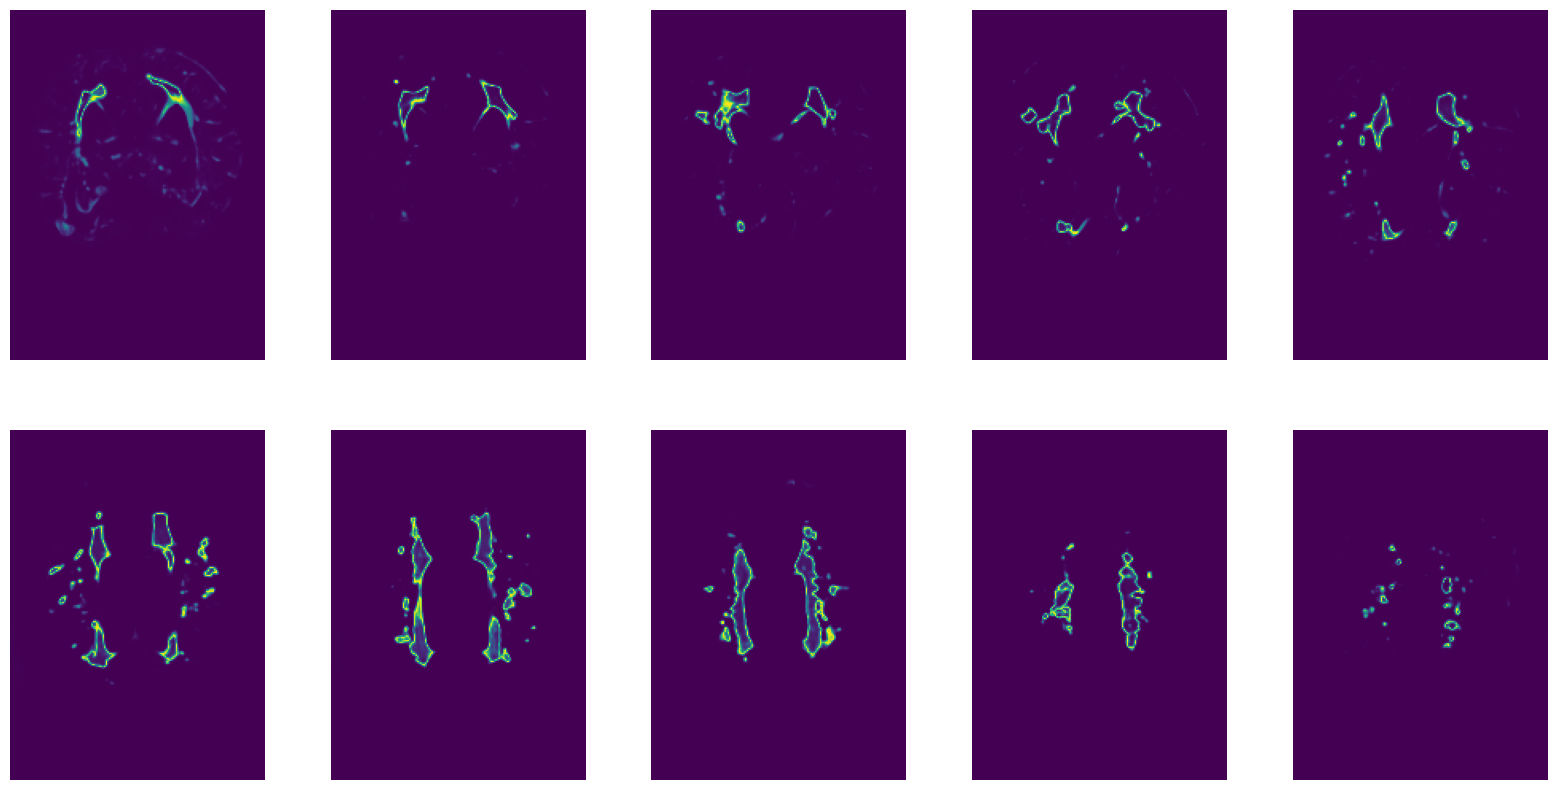

In [20]:
plt.figure(figsize=(20, 10))
for i in range(10):
    plt.subplot(2, 5, i+1)
    plt.imshow(example0[0][0][i*2])
    plt.axis('off')

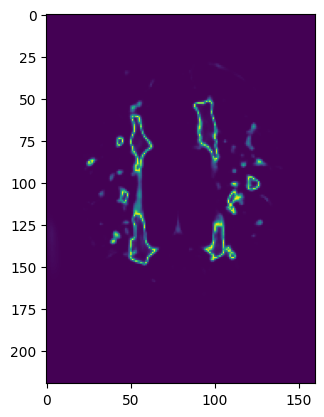

In [21]:
plt.imshow(example0[0][0][11])

### combine the datasets and get dataloaders

In [22]:
train_ds = ConcatDataset([cvd_train, tadni_train])
val_ds = ConcatDataset([cvd_val, cvd_test, tadni_val, tadni_test])

In [23]:
adni_val[0][0][1]

array([-0.02500828,  1.        ], dtype=float32)

In [24]:
val_ds[0][1]

1.0

In [25]:
resampled_val_ds = ResampledDataset(val_ds)

In [26]:
resampled_val_ds[0][1]

0.0

In [27]:
batch_size=12
train_dataloader = DataLoader(train_ds, batch_size=batch_size, sampler=ImbalancedDatasetSampler(GetLabelsDs(train_ds)), num_workers=4)
val_dataloader = DataLoader(resampled_val_ds, batch_size=batch_size, shuffle=False, num_workers=4)

In [28]:
resampled_val_ds[0][0][1]

tensor([-1.6101,  0.0000])

In [29]:
out = next(iter(val_dataloader))

In [30]:
len(train_ds), len(val_ds)

(365, 160)

### Setting up model for training

In [31]:
from functools import partial
from typing import Any, Callable, List, Optional, Type, Union

import torch
import torch.nn as nn
from torch import Tensor


def conv3x3(in_planes: int, out_planes: int, stride: int = 1, groups: int = 1, dilation: int = 1) -> nn.Conv2d:
    """3x3 convolution with padding"""
    return nn.Conv2d(
        in_planes,
        out_planes,
        kernel_size=3,
        stride=stride,
        padding=dilation,
        groups=groups,
        bias=False,
        dilation=dilation,
    )


def conv1x1(in_planes: int, out_planes: int, stride: int = 1) -> nn.Conv2d:
    """1x1 convolution"""
    return nn.Conv2d(in_planes, out_planes, kernel_size=1, stride=stride, bias=False)


class BasicBlock(nn.Module):
    expansion: int = 1

    def __init__(
        self,
        inplanes: int,
        planes: int,
        stride: int = 1,
        downsample: Optional[nn.Module] = None,
        groups: int = 1,
        base_width: int = 64,
        dilation: int = 1,
        norm_layer: Optional[Callable[..., nn.Module]] = None,
    ) -> None:
        super().__init__()
        if norm_layer is None:
            norm_layer = nn.BatchNorm2d
        if groups != 1 or base_width != 64:
            raise ValueError("BasicBlock only supports groups=1 and base_width=64")
        if dilation > 1:
            raise NotImplementedError("Dilation > 1 not supported in BasicBlock")
        # Both self.conv1 and self.downsample layers downsample the input when stride != 1
        self.conv1 = conv3x3(inplanes, planes, stride)
        self.bn1 = norm_layer(planes)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = conv3x3(planes, planes)
        self.bn2 = norm_layer(planes)
        self.downsample = downsample
        self.stride = stride

    def forward(self, x: Tensor) -> Tensor:
        identity = x

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)

        if self.downsample is not None:
            identity = self.downsample(x)

        out += identity
        out = self.relu(out)

        return out


class Bottleneck(nn.Module):
    # Bottleneck in torchvision places the stride for downsampling at 3x3 convolution(self.conv2)
    # while original implementation places the stride at the first 1x1 convolution(self.conv1)
    # according to "Deep residual learning for image recognition" https://arxiv.org/abs/1512.03385.
    # This variant is also known as ResNet V1.5 and improves accuracy according to
    # https://ngc.nvidia.com/catalog/model-scripts/nvidia:resnet_50_v1_5_for_pytorch.

    expansion: int = 4

    def __init__(
        self,
        inplanes: int,
        planes: int,
        stride: int = 1,
        downsample: Optional[nn.Module] = None,
        groups: int = 1,
        base_width: int = 64,
        dilation: int = 1,
        norm_layer: Optional[Callable[..., nn.Module]] = None,
    ) -> None:
        super().__init__()
        if norm_layer is None:
            norm_layer = nn.BatchNorm2d
        width = int(planes * (base_width / 64.0)) * groups
        # Both self.conv2 and self.downsample layers downsample the input when stride != 1
        self.conv1 = conv1x1(inplanes, width)
        self.bn1 = norm_layer(width)
        self.conv2 = conv3x3(width, width, stride, groups, dilation)
        self.bn2 = norm_layer(width)
        self.conv3 = conv1x1(width, planes * self.expansion)
        self.bn3 = norm_layer(planes * self.expansion)
        self.relu = nn.ReLU(inplace=True)
        self.downsample = downsample
        self.stride = stride

    def forward(self, x: Tensor) -> Tensor:
        identity = x

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)
        out = self.relu(out)

        out = self.conv3(out)
        out = self.bn3(out)

        if self.downsample is not None:
            identity = self.downsample(x)

        out += identity
        out = self.relu(out)

        return out


class ResNet(nn.Module):
    def __init__(
        self,
        block: Type[Union[BasicBlock, Bottleneck]],
        layers: List[int],
        channel_size_divide=1,
        num_classes: int = 1000,
        zero_init_residual: bool = False,
        groups: int = 1,
        width_per_group: int = 64,
        replace_stride_with_dilation: Optional[List[bool]] = None,
        norm_layer: Optional[Callable[..., nn.Module]] = None,
    ) -> None:
        super().__init__()
        if norm_layer is None:
            norm_layer = nn.BatchNorm2d
        self._norm_layer = norm_layer

        self.inplanes = 64//channel_size_divide
        self.init_inplanes = self.inplanes
        self.dilation = 1
        if replace_stride_with_dilation is None:
            # each element in the tuple indicates if we should replace
            # the 2x2 stride with a dilated convolution instead
            replace_stride_with_dilation = [False, False, False]
        if len(replace_stride_with_dilation) != 3:
            raise ValueError(
                "replace_stride_with_dilation should be None "
                f"or a 3-element tuple, got {replace_stride_with_dilation}"
            )
        self.groups = groups
        self.base_width = width_per_group
        self.conv1 = nn.Conv2d(3, self.inplanes, kernel_size=7, stride=2, padding=3, bias=False)
        self.bn1 = norm_layer(self.inplanes)
        self.relu = nn.ReLU(inplace=True)
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        self.layer1 = self._make_layer(block, 64//channel_size_divide, layers[0])
        self.layer2 = self._make_layer(block, 128//channel_size_divide, layers[1], stride=2, dilate=replace_stride_with_dilation[0])
        self.layer3 = self._make_layer(block, 256//channel_size_divide, layers[2], stride=2, dilate=replace_stride_with_dilation[1])
        self.layer4 = self._make_layer(block, 512//channel_size_divide, layers[3], stride=2, dilate=replace_stride_with_dilation[2])
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(512 * block.expansion, num_classes)

        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode="fan_out", nonlinearity="relu")
            elif isinstance(m, (nn.BatchNorm2d, nn.GroupNorm)):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)

        # Zero-initialize the last BN in each residual branch,
        # so that the residual branch starts with zeros, and each residual block behaves like an identity.
        # This improves the model by 0.2~0.3% according to https://arxiv.org/abs/1706.02677
        if zero_init_residual:
            for m in self.modules():
                if isinstance(m, Bottleneck) and m.bn3.weight is not None:
                    nn.init.constant_(m.bn3.weight, 0)  # type: ignore[arg-type]
                elif isinstance(m, BasicBlock) and m.bn2.weight is not None:
                    nn.init.constant_(m.bn2.weight, 0)  # type: ignore[arg-type]

    def _make_layer(
        self,
        block: Type[Union[BasicBlock, Bottleneck]],
        planes: int,
        blocks: int,
        stride: int = 1,
        dilate: bool = False,
    ) -> nn.Sequential:
        norm_layer = self._norm_layer
        downsample = None
        previous_dilation = self.dilation
        if dilate:
            self.dilation *= stride
            stride = 1
        if stride != 1 or self.inplanes != planes * block.expansion:
            downsample = nn.Sequential(
                conv1x1(self.inplanes, planes * block.expansion, stride),
                norm_layer(planes * block.expansion),
            )

        layers = []
        layers.append(
            block(
                self.inplanes, planes, stride, downsample, self.groups, self.base_width, previous_dilation, norm_layer
            )
        )
        self.inplanes = planes * block.expansion
        for _ in range(1, blocks):
            layers.append(
                block(
                    self.inplanes,
                    planes,
                    groups=self.groups,
                    base_width=self.base_width,
                    dilation=self.dilation,
                    norm_layer=norm_layer,
                )
            )

        return nn.Sequential(*layers)

    def _forward_impl(self, x: Tensor) -> Tensor:
        # See note [TorchScript super()]
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)

        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)

        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        #x = self.fc(x)

        return x

    def forward(self, x: Tensor) -> Tensor:
        return self._forward_impl(x)


def _resnet(
    block: Type[Union[BasicBlock, Bottleneck]],
    layers: List[int],
    weights,#: Optional[WeightsEnum],
    progress: bool,
    channel_size_divide,
    **kwargs: Any,
) -> ResNet:
    if weights is not None:
        _ovewrite_named_param(kwargs, "num_classes", len(weights.meta["categories"]))

    model = ResNet(block, layers, channel_size_divide, **kwargs)

    if weights is not None:
        model.load_state_dict(weights.get_state_dict(progress=progress))

    return model

def resnet18(*, progress: bool = True, channel_size_divide=2, **kwargs: Any) -> ResNet:
    return _resnet(BasicBlock, [2, 2, 2, 2], None, progress, channel_size_divide=channel_size_divide, **kwargs)

def resnet34(*, progress: bool = True, **kwargs: Any) -> ResNet:

    return _resnet(BasicBlock, [3, 4, 6, 3], None, progress, **kwargs)

In [33]:
# trying to load a model from torch models and finetuning it
from torchvision import models

In [39]:
def set_parameter_requires_grad(model, feature_extracting):
    if feature_extracting:
        for param in model.parameters():
            param.requires_grad = False
            
def initialize_model(model_name, in_channels=20, num_classes=4, feature_extract=True, use_pretrained=True):
    # Initialize these variables which will be set in this if statement. Each of these
    #   variables is model specific.
    model_ft = None
    input_size = 0

    if model_name == "resnet":
        """ Resnet18
        """
        model_ft = models.resnet18(pretrained=use_pretrained)
        set_parameter_requires_grad(model_ft, feature_extract)
        num_ftrs = model_ft.fc.in_features
        model_ft.fc = nn.Linear(num_ftrs, num_classes)
        model_ft.conv1 = nn.Conv2d(in_channels, 64, kernel_size=7, stride=2, padding=3, bias=False)
        model_ft.bn1 = nn.BatchNorm2d(64)
        input_size = 224

    elif model_name == "alexnet":
        """ Alexnet
        """
        model_ft = models.alexnet(pretrained=use_pretrained)
        set_parameter_requires_grad(model_ft, feature_extract)
        num_ftrs = model_ft.classifier[6].in_features
        model_ft.classifier[6] = nn.Linear(num_ftrs,num_classes)
        model_ft.features[0] =  nn.Conv2d(in_channels, 64, kernel_size=11, stride=4, padding=2)
        input_size = 224

    elif model_name == "vgg":
        """ VGG11_bn
        """
        model_ft = models.vgg11_bn(pretrained=use_pretrained)
        set_parameter_requires_grad(model_ft, feature_extract)
        num_ftrs = model_ft.classifier[6].in_features
        model_ft.classifier[6] = nn.Linear(num_ftrs,num_classes)
        model_ft.features[0] = nn.Conv2d(in_channels, 64, kernel_size=3, padding=1)
        model_ft.features[1] = nn.BatchNorm2d(64)
        input_size = 224

    elif model_name == "squeezenet":
        """ Squeezenet
        """
        model_ft = models.squeezenet1_0(pretrained=use_pretrained)
        set_parameter_requires_grad(model_ft, feature_extract)
        model_ft.classifier[1] = nn.Conv2d(512, num_classes, kernel_size=(1,1), stride=(1,1))
        model_ft.features[0] = nn.Conv2d(in_channels, 96, kernel_size=7, stride=2)
        model_ft.num_classes = num_classes
        input_size = 224

    elif model_name == "densenet":
        """ Densenet
        """
        model_ft = models.densenet121(pretrained=use_pretrained)
        set_parameter_requires_grad(model_ft, feature_extract)
        num_ftrs = model_ft.classifier.in_features
        model_ft.classifier = nn.Linear(num_ftrs, num_classes)
        input_size = 224

    elif model_name == "inception":
        raise ValueError("need a different approach to implementing the loss for inception net, see the pytorch finetuning docs for details")
        """ Inception v3
        Be careful, expects (299,299) sized images and has auxiliary output
        """
        model_ft = models.inception_v3(pretrained=use_pretrained)
        set_parameter_requires_grad(model_ft, feature_extract)
        # Handle the auxilary net
        num_ftrs = model_ft.AuxLogits.fc.in_features
        model_ft.AuxLogits.fc = nn.Linear(num_ftrs, num_classes)
        # Handle the primary net
        num_ftrs = model_ft.fc.in_features
        model_ft.fc = nn.Linear(num_ftrs,num_classes)
        input_size = 299

    else:
        print("Invalid model name, exiting...")
        exit()

    return model_ft, input_size




In [86]:
from torchinfo import summary
from torchmetrics import Accuracy

In [50]:
model_name = "resnet"
# Initialize the model for this run
model_ft, input_size = initialize_model(model_name, num_classes=10, feature_extract=True, use_pretrained=True)

# Print the model we just instantiated
summary(model_ft, (12, 20, 224, 160))

/home/s2208943/miniconda3/envs/uq/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/s2208943/miniconda3/envs/uq/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Layer (type:depth-idx)                   Output Shape              Param #
ResNet                                   [12, 10]                  --
├─Conv2d: 1-1                            [12, 64, 112, 80]         62,720
├─BatchNorm2d: 1-2                       [12, 64, 112, 80]         128
├─ReLU: 1-3                              [12, 64, 112, 80]         --
├─MaxPool2d: 1-4                         [12, 64, 56, 40]          --
├─Sequential: 1-5                        [12, 64, 56, 40]          --
│    └─BasicBlock: 2-1                   [12, 64, 56, 40]          --
│    │    └─Conv2d: 3-1                  [12, 64, 56, 40]          (36,864)
│    │    └─BatchNorm2d: 3-2             [12, 64, 56, 40]          (128)
│    │    └─ReLU: 3-3                    [12, 64, 56, 40]          --
│    │    └─Conv2d: 3-4                  [12, 64, 56, 40]          (36,864)
│    │    └─BatchNorm2d: 3-5             [12, 64, 56, 40]          (128)
│    │    └─ReLU: 3-6                    [12, 64, 56, 40]     

In [60]:
class FineTunableModel(torch.nn.Module):
    # uses a modified resnet that bypasses the usual 
    def __init__(self, features_model, num_out_features, num_clin_features, out_classes):
        super().__init__()
        self.model_base = features_model
        self.fc1 = nn.Linear(num_out_features + num_clin_features, out_classes)
        self.a = nn.ReLU()
        
    def forward(self, inp):
        x = inp[0]
        clin_data = inp[1]
        
        # x = None
        
        if x != None:
            features = self.model_base(x)
        else:
            features = torch.zeros(inp[0].shape[0], 512//self.channel_size_divide).cuda()
        dense_input = torch.cat([features, clin_data], dim=1)
        
        out = self.fc1(self.a(dense_input))
        
        return out
        

In [52]:
### selecting a model

class PredictionModel(torch.nn.Module):
    # uses a modified resnet that bypasses the usual 
    def __init__(self, image_channels, num_clin_features, out_classes, latent_fc_features=64, channel_size_divide=2):
        super().__init__()
        model_base = resnet18(channel_size_divide=channel_size_divide)
        self.channel_size_divide = channel_size_divide
        model_base.conv1 = nn.Conv2d(image_channels, model_base.init_inplanes, kernel_size=7, stride=2, padding=3, bias=False)
        
        self.model_base = model_base
        
        # replace the head of the model with another layer.
        self.fc1 = nn.Linear(model_base.fc.in_features//channel_size_divide + num_clin_features, latent_fc_features)
        self.a = nn.ReLU()
        self.fc2 = nn.Linear(latent_fc_features, out_classes)
        
    def forward(self, inp):
        x = inp[0]
        clin_data = inp[1]
        
        # x = None
        
        if x != None:
            features = self.model_base(x)
        else:
            features = torch.zeros(inp[0].shape[0], 512//self.channel_size_divide).cuda()
        dense_input = torch.cat([features, clin_data], dim=1)
        
        out = self.fc2(self.a(self.fc1(dense_input)))
        
        return out
        
        

In [53]:
class xent_wrapper(nn.Module):
    def __init__(self):
        super().__init__()
        self.base_loss = torch.nn.CrossEntropyLoss()
    def forward(self, y_hat, y):
        return self.base_loss(y_hat, y.type(torch.long))

In [54]:
def run_eval_2(mdl, dataloader):
    # reimplementing this, because my old code was behaving strangely....
    
    y_hats = []
    ys = []
    
    for (x, clin_data), y in dataloader:
        with torch.no_grad():
            mdl.eval()
            out = mdl.cuda()((x.cuda(), clin_data.cuda())).cpu()
            y_hat = out.argmax(dim=1)
            y_hats.append(y_hat)
            ys.append(y)
    
    y_hats = torch.cat(y_hats)
    ys = torch.cat(ys)
    
    print(ys.shape, y_hats.shape)
    
    mean_acc = (y_hats == ys).sum() / ys.shape[0]
    
    return mean_acc
            
    
    

In [55]:
train_ds_2d[0][0][0].shape[0]

20

In [ ]:
val_results = []
eval_results = []
for i in range(1):
    image_channels = train_ds_2d[0][0][0].shape[0]
    clin_features = 2
    model_name ="resnet"
    latent_fc_features = 10
    model_ft, input_size = initialize_model(model_name, num_classes=latent_fc_features, feature_extract=False, use_pretrained=True)
    model_raw = FineTunableModel(features_model=model_ft, num_out_features=latent_fc_features, num_clin_features=2, out_classes=4)#.cuda()
    loss = xent_wrapper()
    
    ### training the model
    # setup optimizer and model wrapper

    weight_decay = 0.01#0.05
    max_epochs = 100
    lr=2e-4
    early_stop_patience = 7

    optimizer_params={"lr":lr, "weight_decay":weight_decay}
    optimizer = torch.optim.Adam
    lr_scheduler_params={"milestones":[1000], "gamma":0.5}
    lr_scheduler_constructor = torch.optim.lr_scheduler.MultiStepLR

    # wrap the model in the pytorch_lightning module that automates training
    model = StandardLitModelWrapper(model_raw, loss, 
                                    logging_metric=lambda: Accuracy(task="multiclass", num_classes=4),
                                    optimizer_params=optimizer_params,
                                    lr_scheduler_params=lr_scheduler_params,
                                    optimizer_constructor=optimizer,
                                    lr_scheduler_constructor=lr_scheduler_constructor
                                   )

    # train the model
    trainer = get_trainer(max_epochs, "/disk/scratch_big/s2208943/example_pred_0/", early_stop_patience=early_stop_patience)
    
    trainer.fit(model, train_dataloader, val_dataloader)
    
    model_results = []
    for _ in range(3):
        result = trainer.validate(model, val_dataloader, ckpt_path='best')
#         model_results.append(result[0]['val_loss'])
        
#     val_results.append(torch.Tensor(model_results).mean())
#     print("val score: ", val_results[-1])
        
#     eval_stat = run_eval(model, test_dataloader)
#     print("eval stat: ", eval_stat)
#     eval_results.append(eval_stat)

/home/s2208943/miniconda3/envs/uq/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/s2208943/miniconda3/envs/uq/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
/home/s2208943/miniconda3/envs/uq/lib/python3.10/site-packages/lightning_lite/plugins/environments/slurm.py:167: PossibleUserWarning: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /home/s2208943/min

Sanity Checking: 0it [00:00, ?it/s]

/home/s2208943/miniconda3/envs/uq/lib/python3.10/site-packages/pytorch_lightning/trainer/trainer.py:1595: PossibleUserWarning: The number of training batches (31) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.
  rank_zero_warn(


Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Metric val_loss improved. New best score: 2.106


Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 0.797 >= min_delta = 0.01. New best score: 1.309


Validation: 0it [00:00, ?it/s]

In [ ]:
# question: is the first layer gradient actually being tracked?
# since I am only training the first layer if I see an improvement I could comment on what those layers are learning?


In [ ]:
image_channels

In [ ]:
# check checkpoint changes, (this folder, target, split, run
# switch to doing eval on train val and test.
# plot a batch of the dataset, middle slice

In [ ]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patheffects as PathEffects
from sklearn.metrics import confusion_matrix
from tqdm import tqdm

def plot_confusion_matrix(dataloader, model):
    model.eval()
    all_preds = []
    all_labels = []
    
    with torch.no_grad():
        for (x, clin_data), labels in tqdm(dataloader, position=0, leave=True):
            outputs = model.cuda()((x.cuda(), clin_data.cuda()))
            probs = torch.softmax(outputs, dim=1)
            preds = torch.argmax(probs, dim=1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
    
    cm = confusion_matrix(all_labels, all_preds, normalize='true')
    num_classes = cm.shape[0]
    class_names = [str(i) for i in range(num_classes)]
    
    fig, ax = plt.subplots()
    im = ax.imshow(cm, cmap=plt.cm.Blues)
    ax.set_xticks(np.arange(num_classes))
    ax.set_yticks(np.arange(num_classes))
    ax.set_xticklabels(class_names)
    ax.set_yticklabels(class_names)
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")
    
    
    for i in range(num_classes):
        for j in range(num_classes):
            text = ax.text(j, i, np.round(cm[i, j], 3),
                           ha="center", va="center", color="black")
            text.set_path_effects([PathEffects.withStroke(linewidth=2, foreground='w')])

    
    ax.set_title("Confusion Matrix")
    fig.tight_layout()
    plt.show()

    #return all_preds, all_labels

In [ ]:
# train again check for consistency
# these models train all the weights but start from a pretrained model.
# this is no good though because it overfits very quicky....
# and it looks like the variance is still pretty high.....
plot_confusion_matrix(val_dataloader, model)

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 30/30 [00:49<00:00,  1.65s/it]


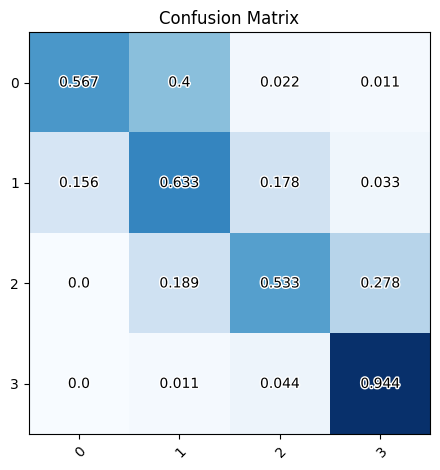

In [99]:
# train again check for consistency
plot_confusion_matrix(val_dataloader, model)

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 30/30 [00:49<00:00,  1.64s/it]


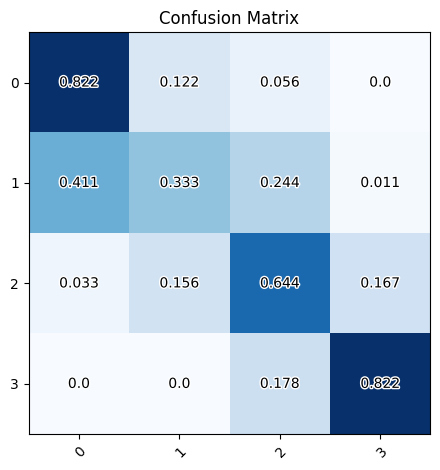

In [93]:
plot_confusion_matrix(val_dataloader, model)

In [70]:
model_ft.conv1.weight.shape

torch.Size([64, 20, 7, 7])

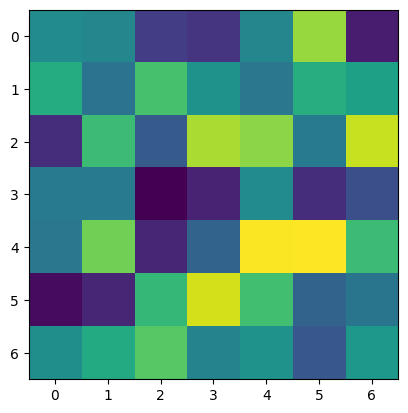

In [75]:
plt.imshow(model_ft.conv1.weight.detach().cpu()[0][2])

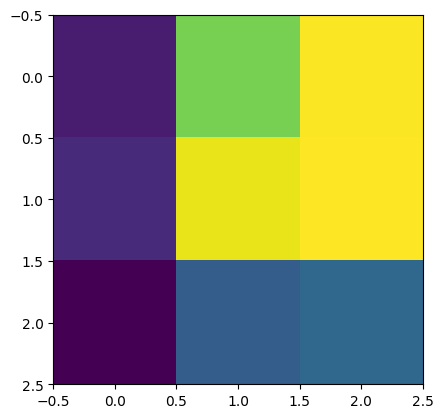

In [83]:
plt.imshow(model_ft.layer1[0].conv1.weight.detach().cpu()[1][2])

In [76]:
summary(model_ft)

Layer (type:depth-idx)                   Param #
ResNet                                   --
├─Conv2d: 1-1                            62,720
├─BatchNorm2d: 1-2                       128
├─ReLU: 1-3                              --
├─MaxPool2d: 1-4                         --
├─Sequential: 1-5                        --
│    └─BasicBlock: 2-1                   --
│    │    └─Conv2d: 3-1                  (36,864)
│    │    └─BatchNorm2d: 3-2             (128)
│    │    └─ReLU: 3-3                    --
│    │    └─Conv2d: 3-4                  (36,864)
│    │    └─BatchNorm2d: 3-5             (128)
│    └─BasicBlock: 2-2                   --
│    │    └─Conv2d: 3-6                  (36,864)
│    │    └─BatchNorm2d: 3-7             (128)
│    │    └─ReLU: 3-8                    --
│    │    └─Conv2d: 3-9                  (36,864)
│    │    └─BatchNorm2d: 3-10            (128)
├─Sequential: 1-6                        --
│    └─BasicBlock: 2-3                   --
│    │    └─Conv2d: 3-11      

In [ ]:
# below are the old confusion matrices for comparison

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 30/30 [00:52<00:00,  1.74s/it]


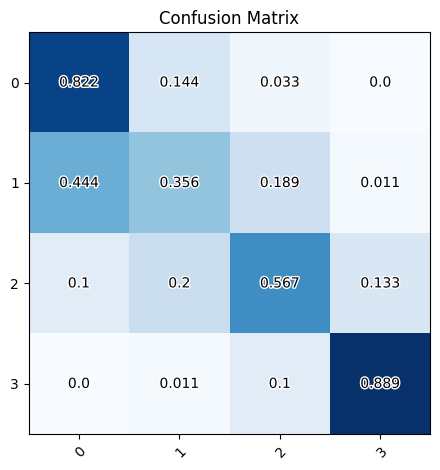

In [201]:
# rebalanced dataset (ent again only)
plot_confusion_matrix(val_dataloader, model)

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 30/30 [00:40<00:00,  1.35s/it]


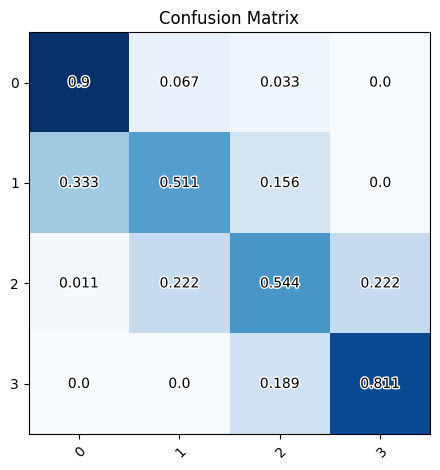

In [170]:
# rebalanced dataset (pred only)
plot_confusion_matrix(val_dataloader, model)

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 30/30 [00:47<00:00,  1.59s/it]


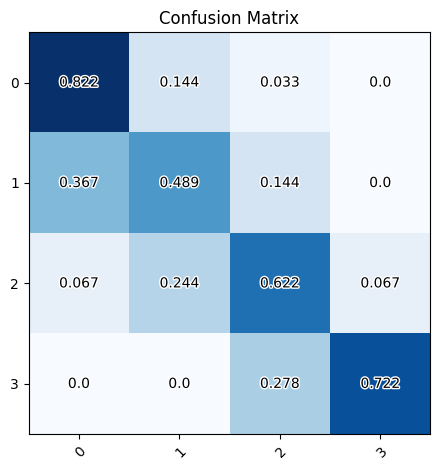

In [143]:
# rebalanced dataset (ent only)
plot_confusion_matrix(val_dataloader, model)